In [ ]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras
import matplotlib.pyplot as plt
from datetime import date

We read the dataset.

In [ ]:
with open('/content/drive/My Drive/dataset.pkl', 'br') as f:
    Xd = cPickle.load(f, encoding='latin1')

We split dataset's constellation points into chunks.

In [ ]:
def divide_chunks(l, n): 
    # looping till length l 
    for i in range(0, len(l), n): 
        print(len(l[i:i + n])) 
        yield l[i:i + n] 

mods = ['qam4', 'qam16', 'qam64']

X = []  
lbl = []
for mod in mods:
  chunksReal = list(divide_chunks(list(map(float, Xd[mod][0])), 128))[:-1]
  chunksImag = list(divide_chunks(list(map(float, Xd[mod][1])), 128))[:-1]
  chunks = list(map(list, zip(chunksReal, chunksImag)))
  X.append(chunks)
  for i in range(len(chunks)):  lbl.append(mod)
X = np.vstack(X)

Splitting our dataset into training and testing data.

The selection of the training and testing data is random.

Training data = 70% of the dataset.

Testing data = 30% of the dataset.

In [ ]:
np.random.seed(date.today().year)
n_examples = X.shape[0]
n_train = n_examples * 0.7
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [ ]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x]), test_idx)))

In [ ]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

# Set up some params 
nb_epoch = 10     # number of epochs to train on
batch_size = 10  # training batch size

from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,Reshape,Dropout,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
def build_cnn_model(in_shape):
  # Declare layers size
  conv1_kernel_shape=(3,1)
  conv1_number_of_filters=64
  conv2_kernel_shape=(3,2)
  conv2_number_of_filters=16
  dense1_size = 128
  dense2_size = 3
  dropout = 0.4

  # Build model
  model_conv = models.Sequential()
  model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
  model_conv.add(Conv2D(conv1_number_of_filters, conv1_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
  model_conv.add(BatchNormalization())
  model_conv.add(MaxPooling2D())
  model_conv.add(Conv2D(conv2_number_of_filters, conv2_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu', kernel_initializer='he_normal'))
  model_conv.add(Flatten())
  model_conv.add(Dropout(rate=1-dropout))
  model_conv.add(Dense(dense1_size, activation='relu', kernel_initializer='he_normal'))
  model_conv.add(Dense(dense2_size, activation='softmax'))

  # Compile model
  model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


  return model_conv

model = build_cnn_model(in_shp)
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, steps_per_epoch=len(train_idx)/batch_size, validation_data=(X_test, Y_test),)
model.summary()

(16405, 2, 128) [2, 128]
Epoch 1/10
1640/1640 [==============================] - 38s 10ms/step - loss: 0.4042 - accuracy: 0.8294 - val_loss: 0.0040 - val_accuracy: 0.9997
Epoch 2/10
1640/1640 [==============================] - 16s 10ms/step - loss: 0.0652 - accuracy: 0.9808 - val_loss: 4.4955e-04 - val_accuracy: 1.0000
Epoch 3/10
1640/1640 [==============================] - 17s 10ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 7.8174e-05 - val_accuracy: 1.0000
Epoch 4/10
1640/1640 [==============================] - 16s 10ms/step - loss: 0.0094 - accuracy: 0.9977 - val_loss: 3.3875e-04 - val_accuracy: 1.0000
Epoch 5/10
1640/1640 [==============================] - 16s 10ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 2.4471e-06 - val_accuracy: 1.0000
Epoch 6/10
1640/1640 [==============================] - 17s 11ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 4.1557e-06 - val_accuracy: 1.0000
Epoch 7/10
1640/1640 [==============================] - 17s 11ms/step - loss: 0

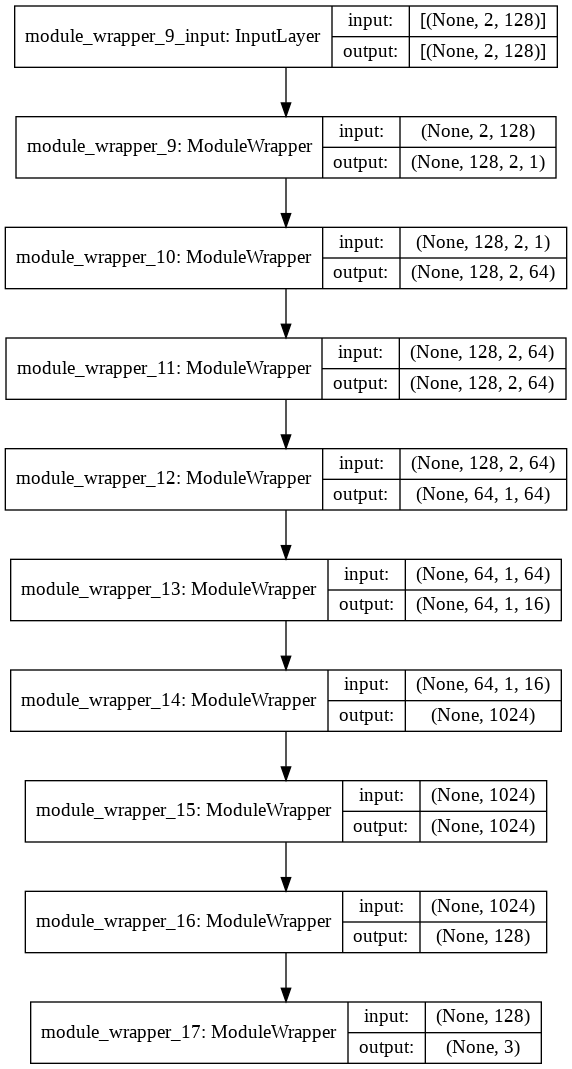

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(model.metrics_names)
print (score)

['loss', 'accuracy']
[0.05759174860024359, 0.93721]


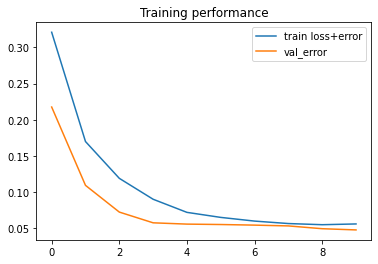

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
history.history['val_loss'][0]=history.history['val_loss'][0]+0.01
print(history.history['loss'][6])
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

plt.savefig('loss.png')

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(X_train[-1], lbl[-1])

We load the testing data.

In [ ]:
with open('/content/drive/My Drive/mmDataset.pkl', 'br') as f:
    Xd1 = cPickle.load(f, encoding='latin1')

In [ ]:
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

mods = ['ofdm']
X1 = []  
lbl1 = []
for mod in mods:
  print(mod)
  chunksReal = list(divide_chunks(list(map(float, Xd1[mod][0])), 128))[:-1]
  chunksImag = list(divide_chunks(list(map(float, Xd1[mod][1])), 128))[:-1]
  chunks = list(map(list, zip(chunksReal, chunksImag)))
  X1.append(chunks)
  for i in range(len(chunks)):  lbl1.append(mod)
X1 = np.vstack(X1)

Prediction for the 16-QAM scheme

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


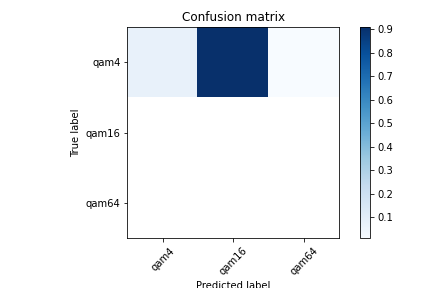

In [16]:
# Plot confusion matrix
X_test = np.vstack(X1[1]).reshape(1, 2, 128)
print(X_test)
test_Y_hat = model.predict(X_test, batch_size=batch_size)
print(test_Y_hat)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = 0
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.savefig('confMatrix16.png')

Prediction for the 64-QAM scheme

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


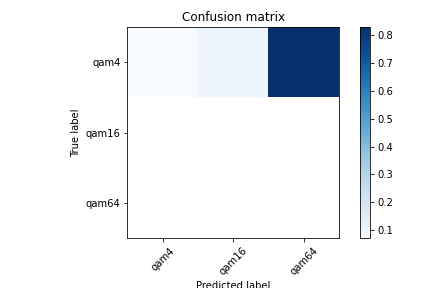

In [17]:
# Plot confusion matrix
X_test = np.vstack(X1[1]).reshape(1, 2, 128)
print(X_test)
test_Y_hat = model.predict(X_test, batch_size=batch_size)
print(test_Y_hat)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = 0
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
plt.savefig('confMatrix64.png')